In [1]:
import math
import numpy as np
import pysindy as ps
import data.DataGenerator as dg
import matplotlib.pyplot as plt

plt.style.use('figstyle.mplstyle')

# Please use the requirements_pysindy.txt to load dependencies for this code.
# I am using this to test J Nathan Kutz and coworkers' SINDy code in Python,
# which is a thresholded least-squares regression method to solve for forms of
# equations governing observable system dynamics from a given library of basis forms.
# The crucial component of this algorithm is a sparsity regulator through TLSQ, a
# a Lasso-like regularizer that iteratively (sequentially) enforces sparsity in the
# solution space when fitting. 

In [69]:
# Let's initialize a series of 2D dynamical systems governed by the Duffing oscillator equation using DataGenerator.
# Each of m_traj trajectories contains m timesteps in n = 2 dimensions.
# This creates a large dataset that is a concatenation of trajectories X.

n = 2
m = 10001
m_traj = 1
dt = 0.2

X0 = np.random.uniform(low = -2.0, high = 2.0, size = (n, m_traj))
Xk = np.zeros((n, m_traj * m))
Xkplus1 = np.zeros((n, m_traj * m))

generator = dg.DataGenerator(X0[:,0], num_steps = m, mapname = "duffing_rk4", dt = dt)

for i in range(m_traj):
    Xi = generator.generate_series(X0[:,i], num_steps = m, noise = False, sigma=0.01, mu=0).T
    Xk[:, i * m : (i+1) * m - 1] = Xi[:, 0:m-1]
    Xkplus1[:, i * m : (i+1) * m - 1] = Xi[:, 1:m]

Text(0.5, 1.0, '2D trajectories of Duffing oscillator, phase space')

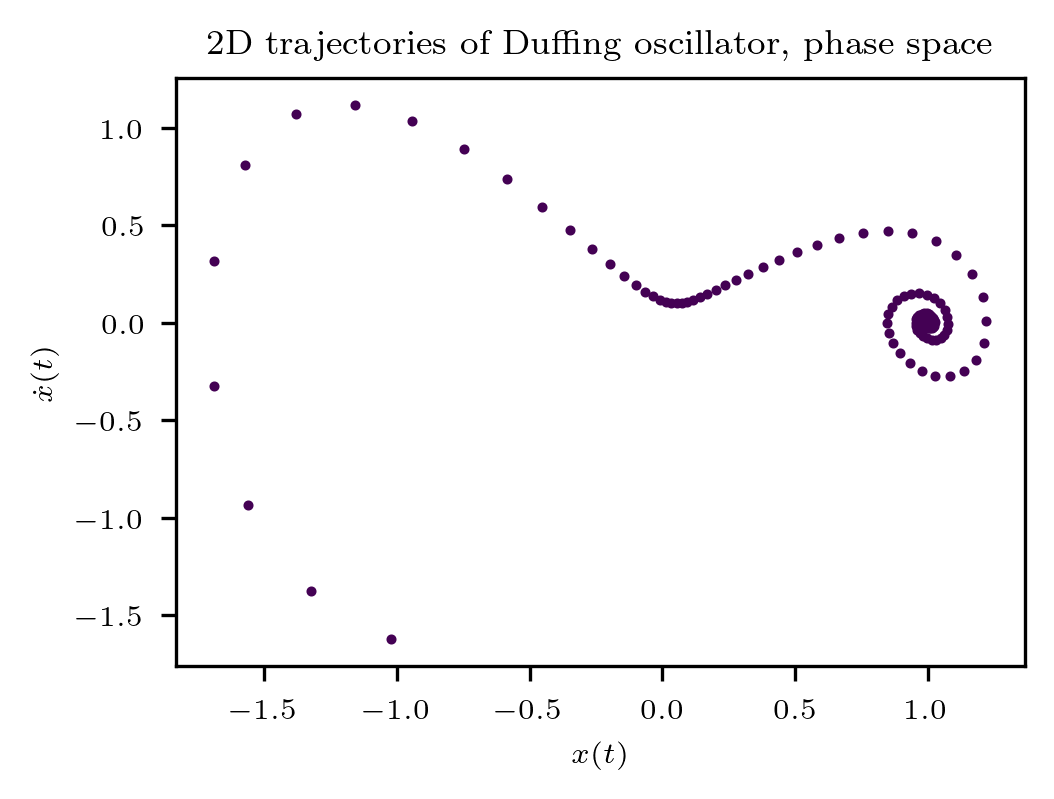

In [70]:
# Let's visualize a couple of trajectories for the sake of example

cm = plt.get_cmap('viridis')
colors = [cm(i/m_traj) for i in range(m_traj)]
 
fig, ax = plt.subplots()
ax.scatter(Xk[0,:m-1], Xk[1,:m-1], s=2, c = colors[0])
ax.set(xlabel=r'$x(t)$', ylabel=r'$\dot{x}(t)$')
ax.set_title("2D trajectories of Duffing oscillator, phase space")

In [59]:
# With the correct threshold on the sequential thresholded least-squares algorithm, we can arrive at an approximation of our analytical solution.

feature_lib = ps.PolynomialLibrary(degree = 3)
optimizer = ps.STLSQ(threshold = 0.2)

model = ps.SINDy(feature_library = feature_lib, optimizer = optimizer)

model.fit(Xk[:,:m-1].T, t = dt, feature_names = ["x1", "x2"])
model.print()

(x1)' = 1.008 x2 + -0.020 x1 x2
(x2)' = 0.990 x1 + -0.494 x2 + -0.990 x1^3


In [5]:
# Now, let's add Gaussian noise to the measurements and see how PySINDY behaves.

n = 2
m = 10001
m_traj = 1
dt = 0.1

X0 = np.random.uniform(low = -2.0, high = 2.0, size = (n, m_traj))
Xk = np.zeros((n, m_traj * m))
Xkplus1 = np.zeros((n, m_traj * m))

generator = dg.DataGenerator(X0[:,0], num_steps = m, mapname = "duffing_rk4", dt = dt)

sigma = 0.01

for i in range(m_traj):
    Xi = generator.generate_series(X0[:,i], num_steps = m, noise = True, sigma=sigma, mu=0).T
    Xk[:, i * m : (i+1) * m - 1] = Xi[:, 0:m-1]
    Xkplus1[:, i * m : (i+1) * m - 1] = Xi[:, 1:m]

/var/folders/pq/1yd98dcd4v5_68_nxtvz_vhm0000gn/T/ipykernel_87578/488761016.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Xk[0,:m-1], Xk[1,:m-1], s=2, c = colors[0])


Text(0.5, 1.0, '2D trajectory of Duffing oscillator (noised, $\\sigma=0.01$)')

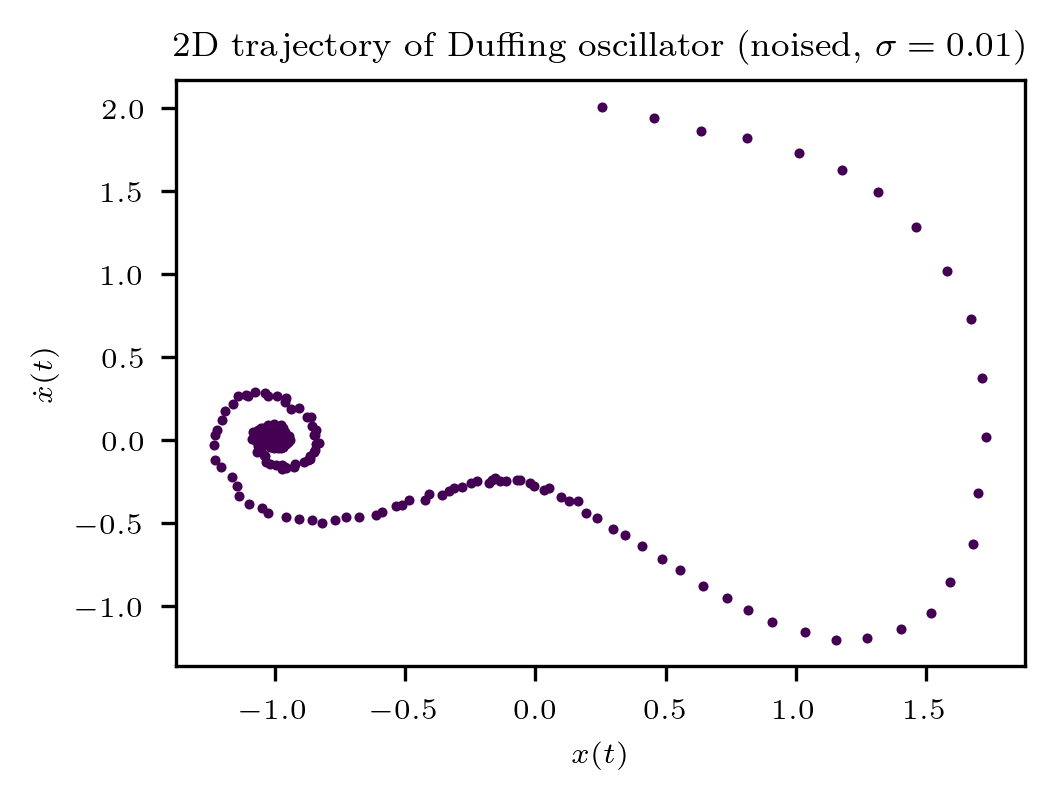

In [6]:
# Let's visualize this noised trajectory for the sake of example

cm = plt.get_cmap('viridis')
colors = [cm(i/m_traj) for i in range(m_traj)]
 
fig, ax = plt.subplots()
ax.scatter(Xk[0,:m-1], Xk[1,:m-1], s=2, c = colors[0])
ax.set(xlabel=r'$x(t)$', ylabel=r'$\dot{x}(t)$')
ax.set_title(rf"2D trajectory of Duffing oscillator (noised, $\sigma={sigma}$)")

In [15]:
# With the correct threshold on the sequential thresholded least-squares algorithm, we can arrive at an approximation of our analytical solution.

feature_lib = ps.PolynomialLibrary(degree = 3)
optimizer = ps.STLSQ(threshold = 0.17)

model = ps.SINDy(feature_library = feature_lib, optimizer = optimizer)

model.fit(Xk[:,:m-1].T, t = dt, feature_names = ["x1", "x2"])
model.print()

(x1)' = 0.972 x2
(x2)' = 0.955 x1 + -0.483 x2 + -0.954 x1^3


**We see that the SINDy method works fairly well on low-dimensional, non-noised data** - being able to reconstruct the form of the analytic equations behind the Duffing oscillator and estimate the coefficients of each term. However, when we linearly apply low-amplitude Gaussian noise to the measurements, holding all else fixed, the method blows up. Again, the noise is not being propagated through the system via the dynamical equations - the trajectory is generated analytically, and then gaussian noise with $\mu=0$, $\sigma = 0.01$ (compared to state variables $x_1, x_2 \in [-2, 2]$) is added to all measurements. 

Considerations and parameter interplay when working with noised data:
* In the Duffing case, noise effects become substantially more pronounced with large dt, i.e., with lower correlation between adjacent states. This is sensible and nonconfigurable in our cochlea case.
* Increasing the number of measurements $m$ does not appear to actually increase or decrease the quality of prediction when noise is present. This is surprising and probably not unilaterally true.
* The result of the SINDy algorithm is highly sensitive to initial conditions (i.e., where in phase space the trajectory accesses). This appears sensible, but does not map uniformly onto "regions with slower dynamics exhibit worse reconstructions" as we'd expect.
* The result of the SINDy algorithm is highly sensitive to the sparsity thresholding level. This is sensible, but we ought to characterize its effect on determined equations.
* In cooperative noised cases, e.g. ($dt = 0.1$, $\sigma = 0.01$), the SINDy algorithm can sometimes generate the correct equations; in this case above, we see that the form is correct but the coefficients have been underestimated, very similar to a previous result from the Koopman EDMD method on this exact system without noise and with fewer measurements (2D Duffing, $dt = 0.1$, $m = 1001$).

What can we try?
* Can we take a single trajectory and subset it into multiple continuous fragments, letting SINDy loose on each fragment and analyzing the ensemble of results that occurs?
* What is the interval dt at which the SINDy algorithm breaks down?
* What is the noising level at which the SINDy algorithm breaks down?
* What is the sparsity thresholding level at which the SINDy algorithm transitions from dense solution -> sparse solution -> no solution? How does this depend on the complexity of the data?
    * What happens when we sweep the sparsity threshold parameter and compare the dynamics induced by each set of estimated equations in phase space?
    * **10/28–10/29: I am building out this visual comparison of estimated trajectories at varying sparsities below.**

Sparsity 0.05: ['0.993*x2', '0.962*x1+-0.458*x2+-0.085*x2**2+-0.962*x1**3+-0.091*x1*x2**2']
Sparsity 0.1: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.15: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.2: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.25: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.3: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.35: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.4: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.45: ['0.993*x2', '0.971*x1+-0.472*x2+-0.971*x1**3']
Sparsity 0.5: ['0.993*x2', '0.971*x1+-0.971*x1**3']


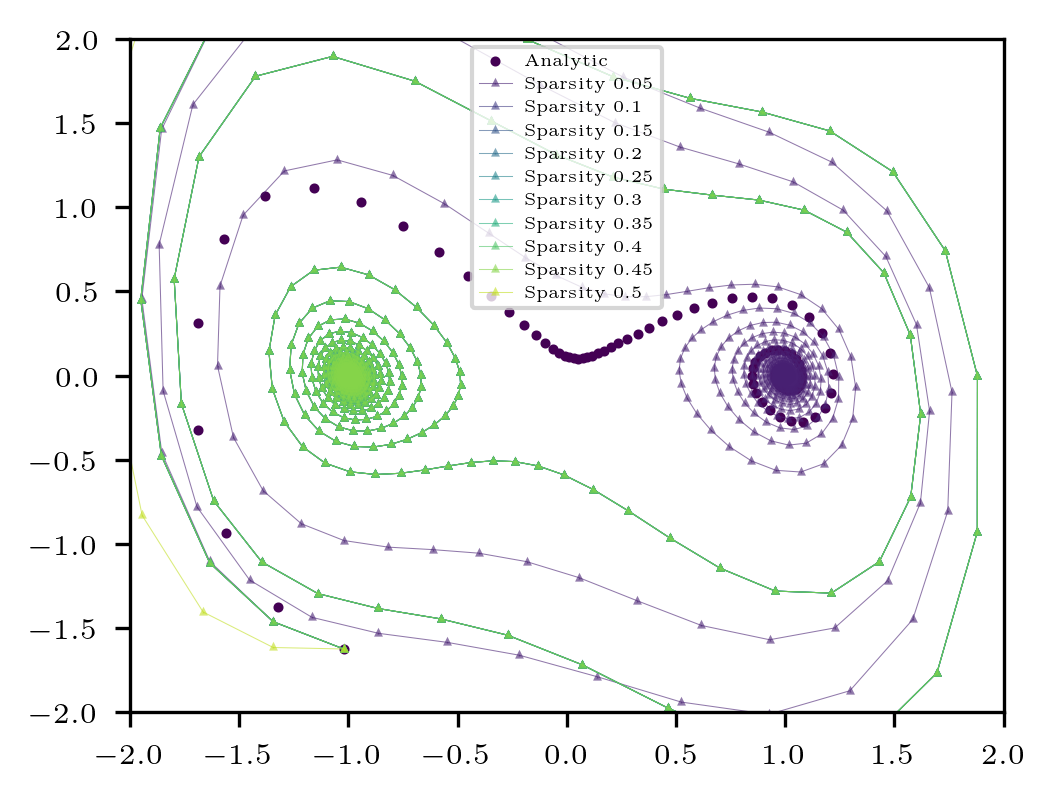

In [153]:
# What happens when we iteratively run SINDy on a noised trajectory, varying the sparsity threshold parameter to obtain distinct equations, and plot
# the evolution of states governed by those equations on the same state space? Do we see recapitulation of the dynamic behavior, or have the dense equations
# missed the mark entirely?

# We can use this method with either noised or non-noised data -the current result being shown is non-noised, from the trajectory generated/shown in cells 2 and 3.
# If we want to try this with noise, just run cells 5 and 6 to generate the noised trajectory and visualize, and then let this subroutine loose.
# However, if we *do* try this with noise, most of the SINDy-determined equations blow up; I've manually set the xlim, ylim to [-2, 2] to visualize what's important,
# but if a lot of states in a trajectory seem to be missing, it is likely that they are somewhere in the range of 10^100 to 10^200...

from sympy import symbols, sympify
from sympy.parsing.sympy_parser import parse_expr
import warnings
warnings.filterwarnings('ignore')

X0 = Xk[:,0]
threshold_sweep = np.linspace(0.05, 0.5, 10)

feature_lib = ps.PolynomialLibrary(degree = 3)

cm = plt.get_cmap('viridis')
colors = [cm(i/(len(threshold_sweep)+1)) for i in range(len(threshold_sweep)+1)]

fig, ax = plt.subplots()
ax.scatter(Xk[0,:m-1], Xk[1,:m-1], s=2, c=colors[0], label=f"Analytic")

# Store equations corresponding to each scalar sparsity threshold for downstream analysis
sparsity_eqn_grid = {}
# Store trajectories corresponding to each scalar sparsity threshold/set of equations, for downstream analysis
sparsity_data_grid = {}
# Store time-series of time derivatives corresponding to each scalar sparsity threshold/set of equations, for downstream analysis
sparsity_statespace_grid = {}
sparsity_derivative_grid = {}

for th in range(len(threshold_sweep)):

    # Construct optimizer at th and fit model
    optimizer = ps.STLSQ(threshold = threshold_sweep[th])
    model = ps.SINDy(feature_library = feature_lib, optimizer = optimizer)
    model.fit(Xk[:,:m-1].T, t = dt, feature_names = ["x1", "x2"])

    # Obtain symbols and expressions of fitted model; use Sympy as interface to parse and store
    x1,x2 = symbols("x1,x2")
    eqns = [parse_expr(eqn.replace(" + ", "+").replace("^", "**").replace(" ", "*"), local_dict={'x1':x1,'x2':x2}) for eqn in model.equations()]
    print(f'Sparsity {np.around(threshold_sweep[th], 3)}: {[eqn.replace(" + ", "+").replace("^", "**").replace(" ", "*") for eqn in model.equations()]}')

    sparsity_eqn_grid[np.around(threshold_sweep[th],3)] = eqns

    X_hat_traj = np.zeros((n, m))
    X_hat_traj[:,0] = X0
    for i in range(m-1):
        X_hat_traj[:,i+1] = X_hat_traj[:,i] + dt * np.array([eqns[0].subs({x1:X_hat_traj[0,i], x2:X_hat_traj[1,i]}), eqns[1].subs({x1:X_hat_traj[0,i], x2:X_hat_traj[1,i]})])

    granularity = 100
    xx = np.linspace(-2, 2, granularity); yy = np.linspace(-2, 2, granularity)
    xgrid, ygrid = np.meshgrid(xx, yy)
    sparsity_statespace_grid[np.around(threshold_sweep[th],3)] = grid
    X_hat_deriv = np.zeros((n, granularity, granularity))
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            X_hat_deriv[0,i,j] = eqns[0].subs({x1:xgrid[i][j], x2:ygrid[i][j]})
            X_hat_deriv[1,i,j] = eqns[1].subs({x1:xgrid[i][j], x2:ygrid[i][j]})
    
    sparsity_data_grid[np.around(threshold_sweep[th],3)] = X_hat_traj
    sparsity_derivative_grid[np.around(threshold_sweep[th],3)] = X_hat_deriv
    
    ax.plot(X_hat_traj[0,:m-1], X_hat_traj[1,:m-1], linewidth=0.25, marker='^', ms=0.5, alpha=0.6, c=colors[th+1], label=f"Sparsity {np.around(threshold_sweep[th], 3)}")
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.legend(fontsize=4)

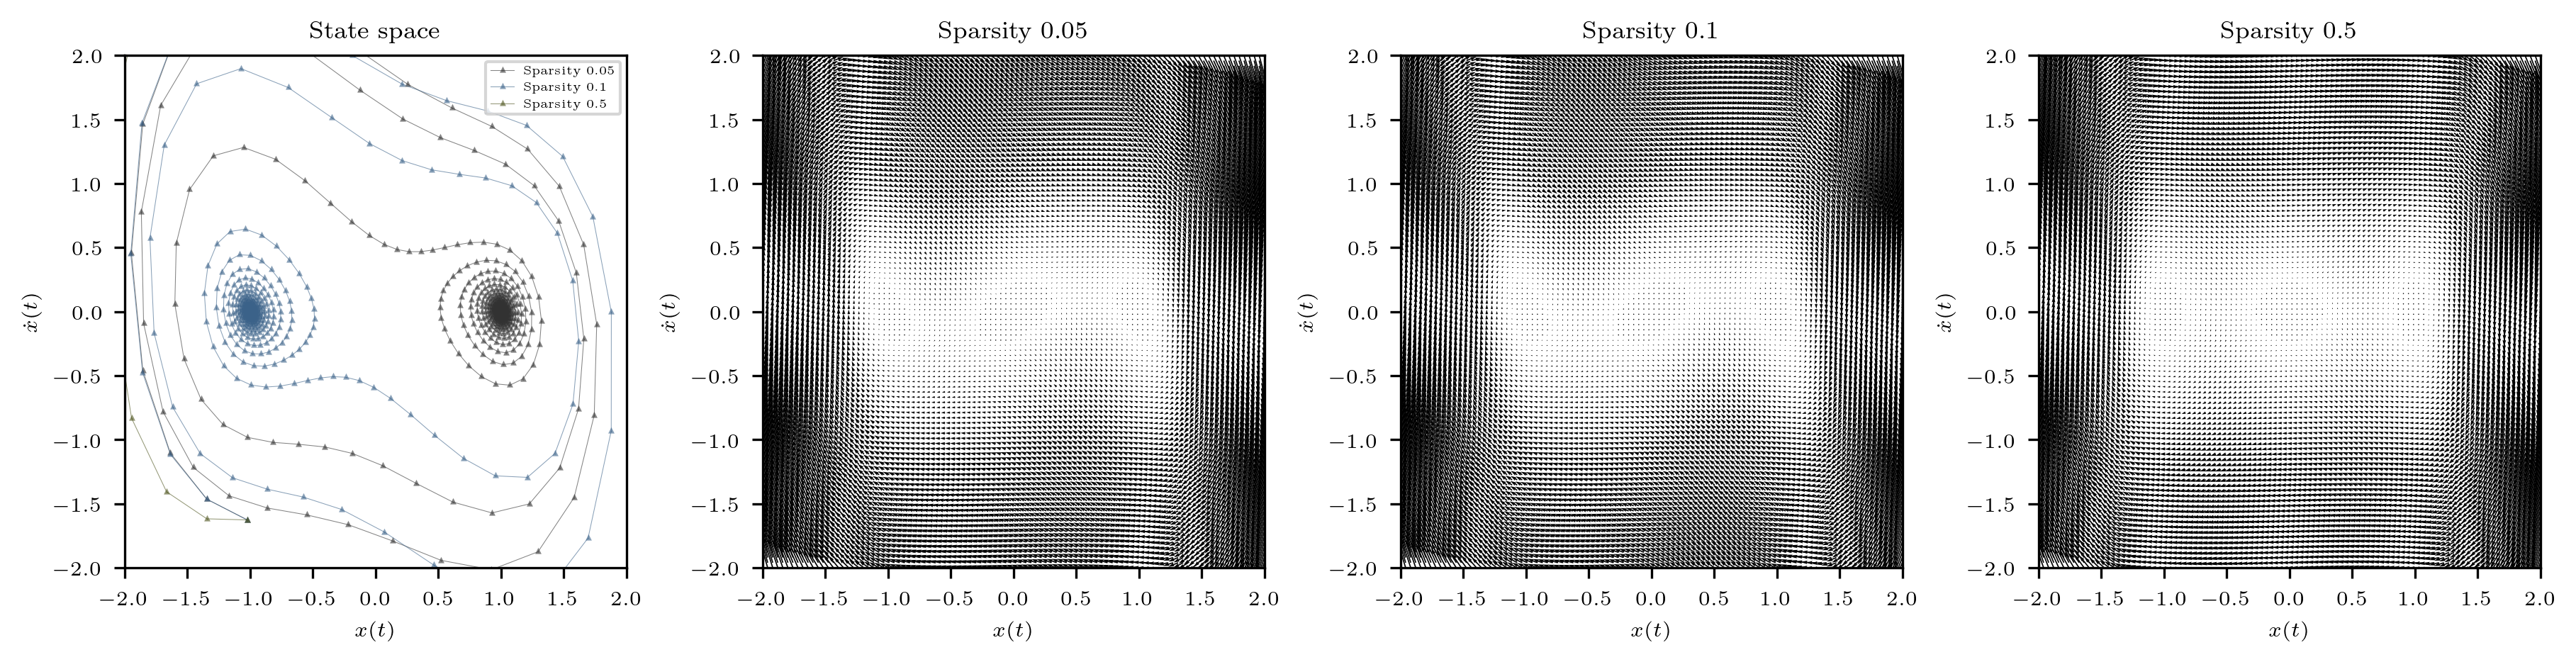

In [173]:
fig, ax = plt.subplots(1,4,figsize=(12,3))
leftbounds = 2
rightbounds = 2
ax[0].set_xlim([-leftbounds,leftbounds]); ax[0].set_ylim([-leftbounds, leftbounds])
for j in [1,2,3]:
    ax[j].set_xlim([-rightbounds,rightbounds]); ax[j].set_ylim([-rightbounds, rightbounds])
    ax[j].set(xlabel=r"$x(t)$", ylabel=r"$\dot{x}(t)$")

c=1
for select in [0.05, 0.1, 0.5]:
    ax[0].plot(sparsity_data_grid[select][0,:], sparsity_data_grid[select][1,:], linewidth=0.25, marker='^', ms = 0.5, alpha = 0.6, label=f'Sparsity {select}')
    
    ax[c].quiver(xgrid, ygrid, sparsity_derivative_grid[select][0,:], sparsity_derivative_grid[select][1,:], angles='xy', scale=20/dt)
    ax[c].set_title(f"Sparsity {select}")
    c+=1

ax[0].set_title("State space")
ax[0].set(xlabel=r"$x(t)$", ylabel=r"$\dot{x}(t)$")
ax[0].legend(fontsize=4)

Let's go back to analysis. Our sparsity parameter sweep led to three independent solutions, one which I'll call "dense" (sparsity = 0.05), containing a lot of terms; one which is near-analytic (sparsity = 0.1–0.45), containing the correct terms and approximated coefficients, and one which is compressed (sparsity = 0.5), which we see eliminates the $\dot{x}(t) = F(\dot{x}(t))$ term in the dynamics for $x_2 = \dot{x}(t)$. Immediately,
* We are fortunate that there is a wide range of sparsity parameters which recovers the analytical equation, which we hope extends across systems. 
* Some information can be gleaned from this phenomenon - perhaps it is that the $\dot{x}(T) \propto \dot{x}(T)$ term is the least 'important' term governing the dynamics, though we should not be so quick to assign such judgements. After all, there are better ways to characterize this, e.g., with the Koopman modes from Koopman EDMD.

**I am interested in building a post-hoc sparsity regularizer on top of the Koopman EDMD method, and will brainstorm.**

Further, inspecting the vector fields induced on $x_1,x_2 \in [-2,2]$ as above, we can see that the gradients/isoclines (not explicitly shown) look strikingly similar between the dense and near-analytic reconstructed systems (0.05 and 0.1, respectively), giving us confidence that the dense, "overfit" equations with non-analytic terms still induces a vector field that roughly reproduces the original. 